Net32(
  (bilinear): Bilinear(in1_features=32, in2_features=32, out_features=128, bias=True)
  (lstm): LSTMCell(128, 128)
  (linear1): Linear(in_features=128, out_features=32, bias=True)
  (linear2): Linear(in_features=128, out_features=32, bias=True)
)
=== Epoch 1-10 ===
=== Epoch 11-20 ===


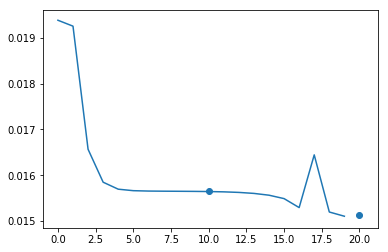

In [1]:
"""
Created on 7/7/18

@author: chefcasey (chefcasey@pm.me)
@coauthor:

@description:
"""

import torch
import torch.nn as nn
from torch.optim import LBFGS

from utils import *

np.random.seed(0)
torch.manual_seed(0)

n_epoch = 2
n_iter = 10
learning_rate = 0.5

future = 100
testi = 0

_train, _test = loader()#建立数据集
input_train = torch.from_numpy(_train[:, :-1, :, :])
output_train = torch.from_numpy(_train[:, 1:, :, :])
input_test = torch.from_numpy(_test[:, :-1, :, :])
output_test = torch.from_numpy(_test[:, 1:, :, :])


class Net32(nn.Module):

    def __init__(self):
        super(Net32, self).__init__()

        self.bilinear = nn.Bilinear(32, 32, 128)
        self.lstm = nn.LSTMCell(128, 128)
        self.linear1 = nn.Linear(128, 32)
        self.linear2 = nn.Linear(128, 32)
#前向传播：
    def forward(self, x, n_fp=0): 
        # print(x.shape)

        h_t = torch.zeros(x.size(0), 128, dtype=torch.double)
        c_t = torch.zeros(x.size(0), 128, dtype=torch.double)

        out = []

        for t, in_t in enumerate(x.chunk(x.size(1), dim=1)):
            in_t.squeeze_()  #去除size为1的维度
            # print(in_t.shape)

            _out = self.bilinear(in_t[:, :, 0], in_t[:, :, 1])
            h_t, c_t = self.lstm(_out, (h_t, c_t))
            _out1 = self.linear1(h_t)
            _out2 = self.linear2(h_t)

            _out = torch.stack((_out1, _out2), dim=2)
            # print(_out.shape)

            out.append(_out)

        # Predict the future
        for idx in range(n_fp):
            _out = self.bilinear(_out1, _out2)
            h_t, c_t = self.lstm(_out, (h_t, c_t))
            _out1 = self.linear1(h_t)
            _out2 = self.linear2(h_t)

            _out = torch.stack((_out1, _out2), dim=2)
            out.append(_out)

        return torch.stack(out, dim=1)


net = Net32()
print(net)

net.double()
criterion = nn.MSELoss()  # TODO: Check MSELoss usage

# Use LBFGS as optimizer since we can load the whole data to train
optimizer = LBFGS(net.parameters(), lr=learning_rate, max_iter=n_iter)  # 0.8

lm = LossMaster()

for i in range(n_epoch):
    print('=== Epoch {0}-{1} ==='.format(i * n_iter + 1, i * n_iter + n_iter))

    def closure():
        optimizer.zero_grad()
        out = net(x=input_train)
        _loss = criterion(out, output_train)

        # print('Train Loss: {}'.format(_loss.item()))
        lm.push(_loss.item())

        _loss.backward()
        return _loss

    optimizer.step(closure)

    with torch.no_grad():#预测
        pred = net(x=input_test, n_fp=future)
        _loss = criterion(pred[:, :-future], output_test)

        # print('Test Loss: {}'.format(_loss.item()))
        lm.push(_loss.item(), (i + 1) * n_iter, 'test')

        y = pred.detach().numpy()

    vis(y[testi], input_test.numpy()[testi], 0,
        'Result on Epoch {}.png'.format((i + 1) * n_iter))

lm.draw()
